In [85]:
# from google.colab import drive
# drive.mount('/content/drive')

In [86]:
# import os
# image_directory_path = '/content/drive/MyDrive/SnakeData'
# os.chdir(image_directory_path)

In [87]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

print(tf.__version__)

2.10.1


In [88]:
# Check for GPU availability
gpu_available = tf.config.list_physical_devices('GPU')

if gpu_available:
    print("GPU is available.")
    # Additional information about the GPUs
    for gpu in gpu_available:
        print("GPU:", gpu)
else:
    print("No GPU available. Using CPU.")


GPU is available.
GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [89]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
CHANNELS = 3
EPOCHS = 200

In [90]:
# interim_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     image_directory_path,
#     shuffle = True,
#     image_size = (IMAGE_SIZE,IMAGE_SIZE),
#     batch_size = BATCH_SIZE
# )

interim_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "snakes",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 3719 files belonging to 10 classes.


In [91]:
# from pathlib import Path

# data_dir = Path(image_directory_path)

# subdirectories = [subdir for subdir in data_dir.iterdir() if subdir.is_dir()]

# subdirectory_counts = {}

# for subdir in subdirectories:
#     items = list(subdir.glob('*'))
#     subdirectory_counts[subdir.name] = len(items)

# print(subdirectory_counts)

In [92]:
interim_class_names = interim_dataset.class_names
interim_class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [93]:
interim_snake_labels = {
    0: 'Rat snake',
    1: 'Cobra',
    2: 'Indian Python',
    3: 'Sand Boa',
    4: 'Hump Nosed Viper',
    5: 'Whip Snake',
    6: 'Sri Lankan Krait',
    7: 'Common Krait',
    8: 'Russell’s Viper',
    9: 'Saw-scaled Viper'
}

In [94]:
len(interim_dataset)

233

In [95]:
for image_batch, label_batch in interim_dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())


(16, 256, 256, 3)
[9 4 1 9 5 8 5 2 5 8 1 1 9 2 2 9]


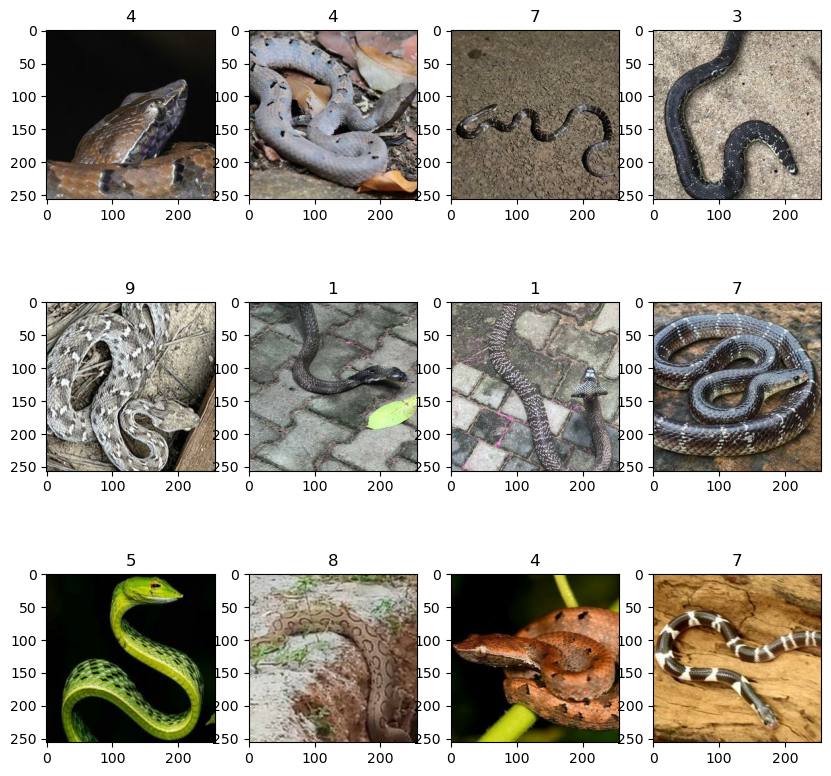

In [96]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in interim_dataset.take(1):
    for i in range (12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(int(label_batch[i]))

In [97]:
train_ds = interim_dataset.take(int(len(interim_dataset)*0.6))
print(len(train_ds))
test_ds = interim_dataset.skip(int(len(interim_dataset)*0.6))
# print(len(test_ds))
val_ds = test_ds.take(int(len(interim_dataset)*0.15))
print(len(val_ds))
test_ds = test_ds.skip(int(len(interim_dataset)*0.15))
print(len(test_ds))

139
34
60


In [98]:
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

In [99]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [100]:
input_shp = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

interim_model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(256,(3,3), activation='relu', input_shape = input_shp),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    
#     layers.Dropout(0.5),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.5),
    
    layers.Dense(len(interim_class_names), activation='softmax')
])

interim_model.build(input_shape=input_shp)

In [101]:
interim_model.summary()



Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_13 (Sequential)  (16, 256, 256, 3)         0         
                                                                 
 sequential_12 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 254, 254, 128)     3584      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 125, 125, 64)      73792     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                

In [102]:
interim_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [103]:
interim_history = interim_model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/200


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential_14/max_pooling2d_15/MaxPool/MaxPoolGrad' defined at (most recent call last):
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\site-packages\ipykernel\kernelapp.py", line 724, in start
      self.io_loop.start()
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\site-packages\ipykernel\kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\site-packages\ipykernel\kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\site-packages\ipykernel\kernelbase.py", line 408, in dispatch_shell
      await result
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\site-packages\ipykernel\kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\site-packages\ipykernel\ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Kimuthu Kisal\AppData\Local\Temp\ipykernel_37476\3077196595.py", line 1, in <module>
      interim_history = interim_model.fit(
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "C:\Users\Kimuthu Kisal\anaconda3\envs\tf210\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential_14/max_pooling2d_15/MaxPool/MaxPoolGrad'
OOM when allocating tensor with shape[16,128,254,254] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_14/max_pooling2d_15/MaxPool/MaxPoolGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_37742]

In [ ]:
scores = interim_model.evaluate(test_ds)

In [ ]:
print(interim_history)
print(interim_history.params)
print(interim_history.history.keys())

In [ ]:
acc = interim_history.history['accuracy']
val_acc = interim_history.history['val_accuracy']
loss = interim_history.history['loss']
val_loss = interim_history.history['val_loss']

plt.figure(figsize=(25,8))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Acccuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

In [ ]:
interim_model.save("final_cnn_001.h5")

In [ ]:
loaded_model = load_model("final_cnn_001.h5")

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",interim_class_names[first_label])

    batch_prediction = interim_model.predict(images_batch)
    print("predicted label:",interim_class_names[np.argmax(batch_prediction[0])])

In [ ]:
# import os
# test_ds = '/content/drive/MyDrive/Kimuthu/snakes'
# os.chdir(test_ds)

In [ ]:
def predict(interim_model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = interim_model.predict(img_array)

    predicted_class = interim_class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
test_snake_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_ds,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os

test_snake_ds_final = tf.keras.preprocessing.image_dataset_from_directory(
    "mix",
    shuffle = False,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE*9
)

# Define a function to get the file name
def get_file_name(image_path):
    # Use os.path.basename to extract only the file name from the path
    return os.path.basename(image_path)

# Create a list to store file names
file_names = []
for images, labels in test_snake_ds_final:
    for image_path in test_snake_ds_final.file_paths:
        file_name = get_file_name(image_path)
        file_names.append(file_name)
    
plt.figure(figsize=(12, 15*10))
plt.axis('off')

for images, labels in test_snake_ds_final:
    for i in range(141):
        ax = plt.subplot(40, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(interim_model, images[i].numpy())
        actual_class = interim_class_names[labels[i]] 
        
#         plt.title(f"Actual: {actual_class}, Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.title(f"File: {file_names[i]} \n Predicted: {interim_snake_labels[int(predicted_class)]}.\n Confidence: {confidence}%")
        plt.axis('off')
# plt.axis("off")

In [ ]:
#interim_model.save("../snakedetectionmodelv2.h5")

In [ ]:
# MODEL = tf.keras.models.load_model("../snakedetectionmodelv2.h5")
# MODEL.save("../snakedetectionmodel.h5")

In [ ]:
# test_snake_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     "test_snake_images",
#     shuffle = True,
#     image_size = (256,256),
#     batch_size = 32
# )

In [ ]:
# def predict(MODEL, img):
#     img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
#     img_array = tf.expand_dims(img_array, 0)

#     predictions = MODEL.predict(img_array)

#     predicted_class = np.argmax(predictions[0])
#     confidence = round(100 * (np.max(predictions[0])), 2)
#     return predicted_class, confidence

In [ ]:
# import numpy as np
# plt.figure(figsize=(10, 10))
# plt.axis('off')

# for images, labels in test_snake_ds.take(1):
#     for i in range(9):

#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))

#         predicted_class, confidence = predict(MODEL, images[i].numpy())
# #         actual_class = interim_class_names[labels[i]]

# #         plt.title(f"Actual: {actual_class}, Predicted: {predicted_class}.\n Confidence: {confidence}%")
#         plt.title(f"Predicted: {int(predicted_class)}.\n Confidence: {confidence}%")
#         plt.axis('off')
# # plt.axis("off")